In [27]:
"""
Quant Macro Final Project: The Model

Innovation and Inequality

The parameter specification given is the baseline model. Increasing the parameter
\rho from 0.2 to 0.6 will replicate extension of the baseline model discussed in the
project.

Joe Emmens
"""

'\nQuant Macro Final Project: The Model\n\nInnovation and Inequality\n\nThe parameter specification given is the baseline model. Increasing the parameter\n\rho from 0.2 to 0.6 will replicate extension of the baseline model discussed in the \nproject.\n\nJoe Emmens\n'

In [28]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import quantecon as qe

path_name = ""
os.chdir(f"{path_name}")

In [29]:
def approx_markov(rho, sigma_u, m=3, n=4):
    """
    A function to approximate a Markov process given the
    coefficient of correlation \rho and variation \sigma
    """

    F = norm(loc=0, scale=sigma_u).cdf

    # standard deviation of y_t
    std_y = np.sqrt(sigma_u**2 / (1-rho**2))

    # top of discrete state space
    x_max = m * std_y

    # bottom of discrete state space
    x_min = - x_max

    # discretized state space
    x = np.linspace(x_min, x_max, n)

    step = (x_max - x_min) / (n - 1)
    half_step = 0.5 * step
    P = np.empty((n, n))

    for i in range(n):
        P[i, 0] = F(x[0]-rho * x[i] + half_step)
        P[i, n-1] = 1 - F(x[n-1] - rho * x[i] - half_step)
        for j in range(1, n-1):
            z = x[j] - rho * x[i]
            P[i, j] = F(z + half_step) - F(z - half_step)

    return x, P

In [30]:
"""
Define the parameters, including the transition matrix.
The persistence parameter is set to 0 at first.
"""
N_theta = 4
p_thetas = [0.2, 0.3, 0.4, 0.6]
bar_w = 3.35
r = 0.019

kMin =  0.01
kMax = 14.8
kNum = 1000
kGrid = np.linspace(kMin, kMax, kNum)
delta = 0.063
beta = 0.98

x, trans_mat = approx_markov(0.2, 0.5, 3, 4)


In [31]:
"""
Define the utility functions, CRRA utiltiy.
"""
@np.vectorize
def CRRA_atk(k, kPrime, bar_w = 3.35, sigma=1.5, r=0.019):
    """ k**(1-alpha) +(1-delta)*k - kPrime CRRA Utility function"""

    q= 1 / (1 + r)

    y = bar_w

    c = y + k - q*kPrime
    if c > 0:

        if sigma > 1:
            u = ((c)**(1 - sigma)) / (1 - sigma)

        elif sigma == 1:
            u = np.log(c)
    else:
        u = -1000000
    return u

@np.vectorize
def CRRA_inn(k, kPrime, p_theta, bar_w = 3.35, sigma=1.5, alpha=0.36, gamma=20, r=0.019):
    """ CRRA Utility function"""

    if k > 0:

        q= 1 / (1 + r)

        pi = p_theta*gamma*k**alpha - bar_w - (1+r)*k

        y = pi

        c = y + (1-delta)*k - q*kPrime
        if c > 0:

            if sigma > 1:
                u = ((c)**(1 - sigma)) / (1 - sigma)

            elif sigma == 1:
                u = np.log(c)
        else:
            u = -1000000
    else:
            u = -1000000

    return u


In [32]:
def Util_atk():
    """
    Utility when the agent remains in autarky
    Define M as u (f (ki ) + (1 -\delta)ki - kj )
    Impose the constraints on capital through C
    s.t. kj =< f (ki) + (1 - \delta)ki
    """

    V_NI = np.zeros(kNum)
    M_NI = np.zeros((kNum, kNum))

    for (idi, k) in enumerate(kGrid):
        for (idj, kPRime) in enumerate(kGrid):



            M_NI[idi, idj] = CRRA_atk(k, kPRime)


    solution = [V_NI, M_NI]

    return solution


def Util_inn():
    """
    Utility when the agent innovates
    Define M as u (f (ki ) + (1 -\delta)ki - kj )
    Impose the constraints on capital through C
    s.t. kj =< f (ki) + (1 - \delta)ki
    """

    V_I = np.zeros((N_theta, kNum))
    M_I = np.zeros((N_theta, kNum, kNum))

    for (idt, p_theta) in enumerate(p_thetas):
        for (idi, k) in enumerate(kGrid):
            for (idj, kPRime) in enumerate(kGrid):

                M_I[idt][idi, idj] = CRRA_inn(k, kPRime, p_theta=p_theta)


    solution = [V_I, M_I]

    return solution

In [33]:
V_I, M_I = Util_inn()
V_NI, M_NI = Util_atk()

In [34]:
"""
In autarky
"""
X_NI = np.zeros(np.shape(M_NI))
for i in range(len(V_NI)):
        X_NI[:, i] = M_NI[:, i] + beta*V_NI[i]

V1_NI = X_NI.max(axis=1)


"""
In innovation market
"""

X_I = np.zeros(np.shape(M_I))
for (idt, p_theta) in enumerate(p_thetas):
    for i in range(kNum):

        V_I = np.dot(trans_mat, V_I)
        X_I[idt][:, i] = M_I[idt][:, i] + beta*V_I[idt][i]

V1_I = X_I.max(axis=2)

value_func_old = np.zeros_like(V_I)
value_func = np.zeros_like(V_I)
innovation = np.zeros_like(V_I)

for (idt, p_theta) in enumerate(p_thetas):

    for i in range(kNum):
        value_func[idt][i] = np.max((V1_NI[i], V1_I[idt][i]))


        if V1_NI[i] > V1_I[idt][i]:
            innovation[idt][i] = 0
        else:
            innovation[idt][i] = 1


In [35]:
"""
V1 onwards Autarky
"""
OptimalPath = [value_func_old, value_func]
Path_VNI = [V_NI, V1_NI]
Path_VI = [V_I, V1_I]
niter = 0

In [36]:
while np.linalg.norm(value_func - value_func_old) > 10**-4 and niter < 275:

    ga = np.zeros((N_theta, kNum))
    gc = np.zeros((N_theta, kNum))

    """
    In autarky
    """
    X_NI = np.zeros(np.shape(M_NI))
    for i in range(len(V_NI)):
            X_NI[:, i] = M_NI[:, i] + beta*V1_NI[i]

    V1_NI = X_NI.max(axis=1)
    Path_VNI.append(V1_NI)
    V1_NI = Path_VNI[-1]

    a_policy_NI = np.argmax(X_NI, axis=1)

    """
    In innovation market
    """

    X_I = np.zeros(np.shape(M_I))
    for (idt, p_theta) in enumerate(p_thetas):
        for i in range(kNum):

            V1_I = np.dot(trans_mat, V1_I)
            X_I[idt][:, i] = M_I[idt][:, i] + beta*V1_I[idt][i]

    a_policy_I = np.argmax(X_I, axis=2)

    V1_I = X_I.max(axis=2)
    Path_VI.append(V1_I)
    V1_I = Path_VI[-1]

    innovation = np.zeros_like(V_I)
    value_func = np.zeros_like(V_I)

    for (idt, p_theta) in enumerate(p_thetas):

        for i in range(kNum):
            value_func[idt][i] = np.max((V1_NI[i], V1_I[idt][i]))


            if V1_NI[i] > V1_I[idt][i]:
                innovation[idt][i] = 0
                ga[idt, i] = kGrid[a_policy_NI[i]]
            else:
                innovation[idt][i] = 1
                ga[idt, i] = kGrid[a_policy_I[idt, i]]


    OptimalPath.append(value_func)
    value_func_old = OptimalPath[-2]
    value_func = OptimalPath[-1]

    niter = niter+1



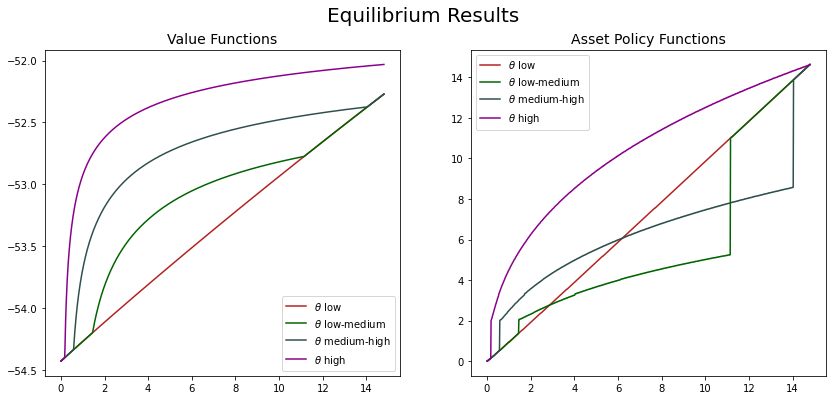

In [37]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, facecolor="w", figsize=(14,6))
fig.suptitle("Equilibrium Results", fontsize=20)

ax1.plot(kGrid, value_func[0,:], label=r"$\theta$ low", c="firebrick")
ax1.plot(kGrid, value_func[1,:], label=r"$\theta$ low-medium", c="darkgreen")
ax1.plot(kGrid, value_func[2,:], label=r"$\theta$ medium-high", c="darkslategrey")
ax1.plot(kGrid, value_func[3,:], label=r"$\theta$ high", c="darkmagenta")

ax1.set_title("Value Functions", fontsize=14)
ax1.legend()

ax2.plot(kGrid, ga[0,:], label=r"$\theta$ low", c="firebrick")
ax2.plot(kGrid, ga[1,:], label=r"$\theta$ low-medium", c="darkgreen")
ax2.plot(kGrid, ga[2,:], label=r"$\theta$ medium-high", c="darkslategrey")
ax2.plot(kGrid, ga[3,:], label=r"$\theta$ high", c="darkmagenta")

ax2.set_title("Asset Policy Functions", fontsize=14)
ax2.legend()

fig.savefig("Inc rho, Eq Results, partial")

In [38]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def invar_dist(ga, trans_mat, kGrid):
    T = 500
    N_a = 10000
    k_state = np.zeros((T, N_a))
    k_state[0, :] = kGrid[find_nearest(kGrid,1)]
    mean_k = np.empty(T)
    var_k = np.empty(T)
    median_k = np.empty(T)

    shock = np.zeros((T, N_a))
    np.random.seed(1)
    for n in range(N_a):

        shock[0, n] = np.random.choice((0,4), 1)


    for t in range(1, T):
        for n in range(N_a):

            if shock[t-1, n] == 0:

                shock[t, n] = np.random.choice((0,1, 2,3), 1, p=trans_mat[0,:])

            if shock[t-1, n] == 1:

                shock[t, n] = np.random.choice((0,1, 2,3), 1, p=trans_mat[1,:])

            if shock[t-1, n] == 2:

                shock[t, n] = np.random.choice((0,1, 2,3), 1, p=trans_mat[2,:])

            if shock[t-1, n] == 3:

                shock[t, n] = np.random.choice((0,1, 2,3), 1, p=trans_mat[3,:])


            if k_state[t-1, n] < median_k[t-1]:

                k_state[t,n] = ga[int(shock[t, n])][find_nearest(kGrid,k_state[t-1,n])] #+ (median_k[t-1]  / 50 )

            if k_state[t-1, n] >= median_k[t-1]:

                k_state[t,n] = ga[int(shock[t, n])][find_nearest(kGrid,k_state[t-1,n])] #- (median_k[t-1] / 50)

        mean_k[t] = np.mean(k_state[t,:])
        var_k[t] = np.var(k_state[t,:])
        median_k[t] = np.median(k_state[t,:])

    k_dist = k_state[T-45:T,:]
    k_dist = k_dist.transpose().flatten()

    Ea = np.sum(k_dist)/N_a

    solution = [T, N_a, k_dist, k_state, Ea, mean_k, var_k, median_k, shock]

    return solution

In [39]:
T, N_a, k_dist, k_state, Ea, mean_k, var_k, median_k, shock = invar_dist(ga, trans_mat, kGrid)

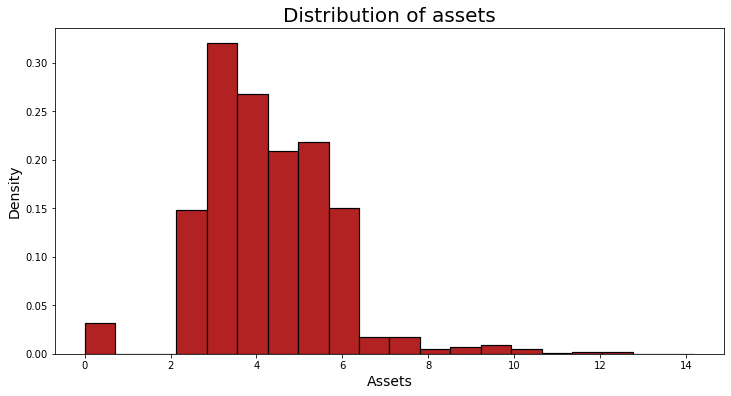

In [40]:
n_bins=20

fig, ax1 = plt.subplots(facecolor="w", figsize=(12,6))
ax1.hist(k_dist, bins=n_bins, label="assets", edgecolor='black', linewidth=1.2, density=1, color="firebrick")
plt.title("Distribution of assets", fontsize=20)
plt.xlabel("Assets", fontsize=14)
plt.ylabel("Density", fontsize=14)

fig.savefig("Inc rho, Asset Dist")

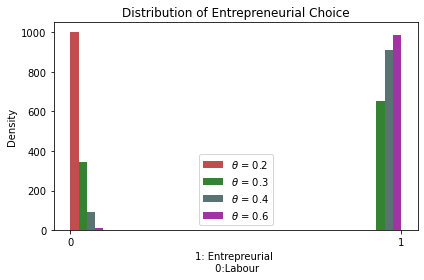

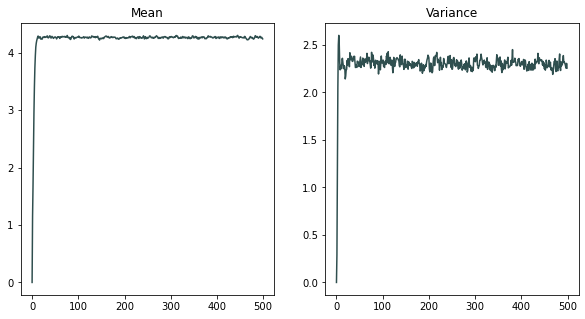

In [41]:
fig, ax = plt.subplots(facecolor="w")
plt.hist([innovation[0], innovation[1],innovation[2], innovation[3]],
         label=[fr"$\theta$ = {p_thetas[0]}",fr"$\theta$ = {p_thetas[1]}",
                fr"$\theta$ = {p_thetas[2]}",fr"$\theta$ = {p_thetas[3]}"],
         color=["firebrick","darkgreen",
                                                                                                                   "darkslategrey", "darkmagenta"],alpha=0.8, rwidth=3)
plt.legend()
plt.title("Distribution of Entrepreneurial Choice")
plt.xlabel("1: Entrepreurial \n 0:Labour")
plt.xticks((0, 1))
plt.ylabel("Density")
plt.tight_layout()
fig.savefig("Inc rho, Innovation dist")


fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, facecolor="w", figsize=(10, 5))

ax1.plot(np.arange(T), mean_k, c="darkslategrey")
ax1.set_title("Mean")
ax2.plot(np.arange(T), var_k, c="darkslategrey")
ax2.set_title("Variance")
plt.show()
fig.savefig("Inc rho, mar and var")

In [42]:
for level in [0, 1, 2, 3]:
    unique_elements, counts_elements = np.unique(innovation[level], return_counts=True)
    print(f"Idea {level}, Frequency of unique values of the said array:")
    print(np.asarray((unique_elements, (counts_elements/400) * 100)))

Idea 0, Frequency of unique values of the said array:
[[  0.]
 [250.]]
Idea 1, Frequency of unique values of the said array:
[[  0.     1.  ]
 [ 86.25 163.75]]
Idea 2, Frequency of unique values of the said array:
[[  0.     1.  ]
 [ 22.75 227.25]]
Idea 3, Frequency of unique values of the said array:
[[  0.   1.]
 [  3. 247.]]


In [43]:
unique_elements_total, counts_elements_total = np.unique(innovation, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements_total, (counts_elements_total/400) * 100)))

Frequency of unique values of the said array:
[[  0.   1.]
 [362. 638.]]


In [44]:
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    array = array.flatten()
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

In [45]:
gini(k_dist)

0.18713519200856843

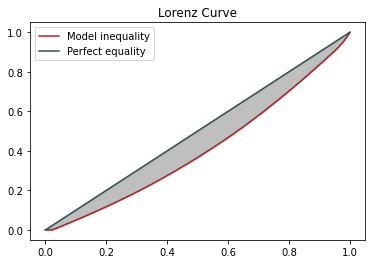

In [46]:
f_vals, l_vals = qe.lorenz_curve(k_dist)

fig, ax = plt.subplots(facecolor="w")
ax.plot(f_vals, l_vals, label="Model inequality", c="firebrick")
ax.plot(f_vals, f_vals, label="Perfect equality", c="darkslategrey")
plt.fill_between(f_vals, l_vals, f_vals, color="grey", alpha=0.5 )
ax.legend()
plt.title("Lorenz Curve")
plt.show()
fig.savefig("Base, lorenz curve")


In [47]:
trans_mat = np.round(trans_mat, 3)

trans_mat

array([[0.077, 0.653, 0.266, 0.004],
       [0.033, 0.548, 0.407, 0.012],
       [0.012, 0.407, 0.548, 0.033],
       [0.004, 0.266, 0.653, 0.077]])